#**load the badnet and the training data from  Google drive**


In [1]:
!pip install tensorflow_model_optimization
from google.colab import drive
drive.mount('/content/drive')
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020

     |████████████████████████████████| 213 kB 5.2 MB/s 
Mounted at /content/drive
Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 1 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 29.56 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
import tempfile
import os
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

%load_ext tensorboard

***Data loader***

In [5]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

clean_data_filename = str('/content/drive/MyDrive/project/clean_validation_data.h5')
test_data_filename = str('/content/drive/MyDrive/project/clean_test_data.h5')
train_images, train_labels=data_loader(clean_data_filename)
train_images=data_preprocess(train_images)
#print("Shape of train_images: {0}".format(train_images.shape))
#print("Shape of train_labels: {0}".format(train_labels.shape))

tune_images, tune_labels=data_loader(clean_data_filename)
tune_images=data_preprocess(tune_images)

***set the parameters for pruning***

In [7]:
import tensorflow_model_optimization as tfmot
prune_low_magnitude=tfmot.sparsity.keras.prune_low_magnitude
batch_size = 64
epochs_test = np.array([2, 4, 6, 8, 10,12,14,16,18,20])
validation_split = 0.1

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.8, 0),
    'block_size': (1, 1),
    'block_pooling_type': 'AVG'
}

#choose the last layer for pruning
def apply_pruning_to_dense(layer):
  if layer.name in ['conv_3']:
    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

In [8]:
K.clear_session()

***BadNet2: anonymous1 poisoned***

In [9]:
model_filename = str('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

***load the poisoned data for BadNet2***

In [10]:
anonymous_data_filename = str('/content/drive/MyDrive/project/anonymous_1_poisoned_data.h5')

In [11]:
##implement the pruning
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [12]:
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(anonymous_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9434918165206909
Epochs=2 (poisoned data) - attack success rate: 0.794622004032135
Epochs=4 (clean data) - pruned test accuracy: 0.909197211265564
Epochs=4 (poisoned data) - attack success rate: 0.6616328954696655
Epochs=6 (clean data) - pruned test accuracy: 0.9183943867683411
Epochs=6 (poisoned data) - attack success rate: 0.5869057178497314
Epochs=8 (clean data) - pruned test accuracy: 0.90623539686203
Epochs=8 (poisoned data) - attack success rate: 0.2871200442314148
Epochs=10 (clean data) - pruned test accuracy: 0.9048324227333069
Epochs=10 (poisoned data) - attack success rate: 0.20956741273403168
Epochs=12 (clean data) - pruned test accuracy: 0.9212003350257874
Epochs=12 (poisoned data) - attack success rate: 0.18394388258457184
Epochs=14 (clean data) - pruned test accuracy: 0.9204988479614258
Epochs=14 (poisoned data) - attack success rate: 0.0571901798248291
Epochs=16 (clean data) - pruned test accuracy: 0.9120030999183655
Epochs

Text(0, 0.5, 'attack success rate')

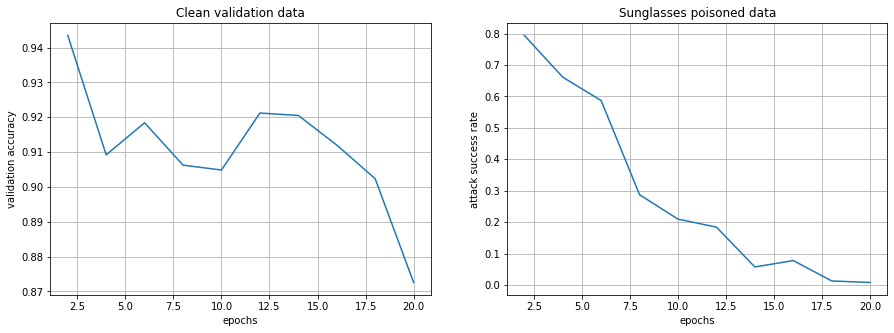

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('Sunglasses poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

***BadNet: anonymous2 poisoned***

In [15]:
anonymous_data_filename = str('/content/drive/MyDrive/project/eyebrows_poisoned_data.h5')

In [17]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
#model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9069368839263916
Epochs=2 (poisoned data) - attack success rate: 0.0002922837156802416
Epochs=4 (clean data) - pruned test accuracy: 0.9050662517547607
Epochs=4 (poisoned data) - attack success rate: 0.0002922837156802416
Epochs=6 (clean data) - pruned test accuracy: 0.9036632776260376
Epochs=6 (poisoned data) - attack success rate: 0.0002922837156802416
Epochs=8 (clean data) - pruned test accuracy: 0.9016367793083191
Epochs=8 (poisoned data) - attack success rate: 0.00019485580560285598
Epochs=10 (clean data) - pruned test accuracy: 0.9003117680549622
Epochs=10 (poisoned data) - attack success rate: 0.0002922837156802416
Epochs=12 (clean data) - pruned test accuracy: 0.9014029502868652
Epochs=12 (poisoned data) - attack success rate: 9.742790280142799e-05
Epochs=14 (clean data) - pruned test accuracy: 0.894076406955719
Epochs=14 (poisoned data) - attack success rate: 0.0002922837156802416
Epochs=16 (clean data) - pruned test accuracy: 0.

Text(0, 0.5, 'attack success rate')

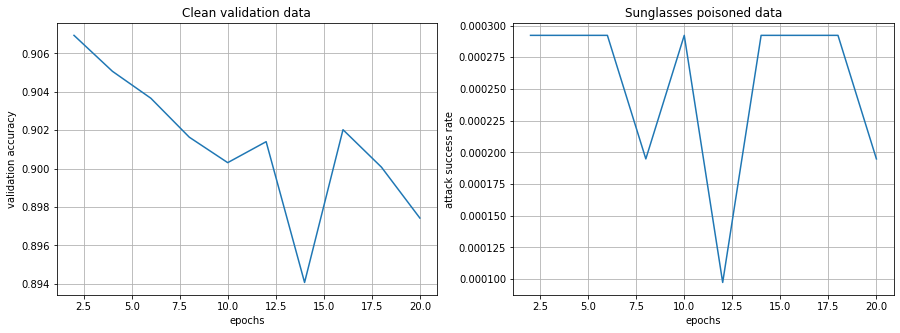

In [18]:
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(anonymous_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_test, clean_accuracy)
plt.title('Clean validation data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_test, poison_accuracy, label='Poison')
plt.title('Sunglasses poisoned data')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('attack success rate')

***BadNet4:multi trigger & multi target poisoned***

In [19]:
K.clear_session()

In [20]:
model_filename = str('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')
bd_model = keras.models.load_model(model_filename)
##bd_model.summary()

In [21]:
multi_data_filename = str('/content/drive/MyDrive/project/lipstick_poisoned_data.h5')

In [22]:
model_for_pruning=tf.keras.models.clone_model(
    bd_model,
    clone_function=apply_pruning_to_dense,
)
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[1][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[1][0]']                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [23]:
#train and evaluate the model against baseline -- fine-tuning
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

clean_accuracy = np.zeros(epochs_test.shape[0])
poison_accuracy = np.zeros(epochs_test.shape[0])
for i, epochs in enumerate(epochs_test):
  model_for_pruning.fit(tune_images, tune_labels,
                    batch_size=batch_size, epochs=epochs, 
                    callbacks=callbacks, verbose=0)
  #test clean data accuracy
  test_images, test_labels = data_loader(test_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  clean_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (clean data) - pruned test accuracy: {1}'.format(epochs, model_for_pruning_accuracy))
  #test poison data accuracy
  test_images, test_labels = data_loader(multi_data_filename)
  test_images=data_preprocess(test_images)
  _, model_for_pruning_accuracy = model_for_pruning.evaluate(
    test_images, test_labels, verbose=0)
  poison_accuracy[i] = model_for_pruning_accuracy
  print('Epochs={0} (poisoned data) - attack success rate: {1}'.format(epochs, model_for_pruning_accuracy))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epochs=2 (clean data) - pruned test accuracy: 0.9476227760314941
Epochs=2 (poisoned data) - attack success rate: 0.8670108914375305
Epochs=4 (clean data) - pruned test accuracy: 0.9063133001327515
Epochs=4 (poisoned data) - attack success rate: 0.7860483527183533
Epochs=6 (clean data) - pruned test accuracy: 0.9210444092750549
Epochs=6 (poisoned data) - attack success rate: 0.5938230752944946
Epochs=8 (clean data) - pruned test accuracy: 0.9071707129478455
Epochs=8 (poisoned data) - attack success rate: 0.3132307231426239
Epochs=10 (clean data) - pruned test accuracy: 0.9091192483901978
Epochs=10 (poisoned data) - attack success rate: 0.17059625685214996
Epochs=12 (clean data) - pruned test accuracy: 0.8881527781486511
Epochs=12 (poisoned data) - attack success rate: 0.07248636335134506
Epochs=14 (clean data) - pruned test accuracy: 0.9139516949653625
Epochs=14 (poisoned data) - attack success rate: 0.0037996883038431406
Epochs=16 (clean data) - pruned test accuracy: 0.9098986983299255